<h1 align="center"> Modèles de contagion: revue de littérature et implémentation </h1> 
<h2 align="center"> Enzo Buthiot, Nicolas Gallo ~ A.M.S.E. </h2> 


<hr>

## Table des matières

[1. Revue de littérature](#l1)  
- [1.1. Un premier modèle de diffusion: *le modèle de Bass*](#l1.1)
- [1.2. Un modèle de diffusion classique: *le modèle SIR*](#l1.2)  
- [1.3. Empirical approach](#l1.3)  

[2. Implémentation du modèle **SIS**](#l2)  

<hr>

<a id = "l1"></a>
# 1. Revue de littérature

<a id = "l1.1"></a>
 ## 1.1. Un premier modèle de diffusion: *le modèle de Bass*

A l'origine, ce modèle a été developpé pour décrire le porcessus selon lequel un nouveau produit est adopté par une population donnée. Cependant, il peut aussi etre utilisé comme modèle de propagation virale.
<br>
Le modèle est décris par l'équation différentielle suivante:
$$ F(t) = F(t-1) + p(1 - F(t-1)) + q(1 - F(t-1))F(t-1),  $$

avec $F(t)$ la fraction des agents infectés au temps $t$, $p$ le taux d'infection et $q$ le taux de contagion.

Ainsi, le terme $p(1 - F(t-1))$ correspond au taux d'infection multiplié par la part des agents non-infectés et $q(1 - F(t-1))F(t-1)$ correspond au taux de contagion mulitplié par la fréquence de recontre entre agents saints et agents infectés.

Le modèle permet donc de capturer 2 phénomènes expliquant l'épidemie: le phénomène d'infection exogène (donné par $p$), et le phénomène de contagion des agents infectés (donné par $q$) .

Le choix des paramètres du modèle est crucial pour les performances du modèle. En particulier, si $p>q$ la courbe de diffusion est croissante et concave; alors que pour $p<q$ la courbe est en forme de S, capturant alors le phénomène de saturation existant empiriquement. Cette seconde spécification est donc préférable.

<a id = "l1.2"></a>
 ## 1.2. Un modèle de diffusion classique: *le modèle SIR*

Dans un tel modèle, les agent appartiennent succesivement à trois groupes:
- **S**uceptible
- **I**nfected
- **R**ecovered


La dynamique de l'épidémie est alors donnée par les taux de transition entre compartiments. 
<br>
Entre **S** et **I** d'abord, le taux de transition est $\frac{\beta I}{N}$, où $\beta$ capture la probabilité de transmission du virus par contact entre agents saints et infectés, multiplié par le nombre moyen de contact par personne; et  $\frac{I}{N}$ représente la part des contacts totaux impliquant un individu infecté.

Ensuite, entre **I** et **R**, le taux de transition théorique est donné par $ \gamma = \frac{1}{D}$, avec $D$ la durée de l'infection pour l'individu. De cette manière, $\gamma$ représente le taux de guérison. Empiriquement, $\gamma$ est simplement le nombre d'agents guéris divisé par le nombre de nouveaux infectés en une période de temps donnée (une journée par exemple).
<br>
Théoriquement, $D$ est généralement défini, pour chaque individu, par une variable aléatoire avec distribution exponentielle.
<br>
<br>
Ce modèle performe bien mieux que le *modèle de Bass* empiriquement, puisqu'il prend additionnellement en compte l'évolution du stock d'infectés potentiels, ce dernier diminuant suite à la mort et/ou à la guérison de certains infectés.

<a id = "l1.3"></a>
 ## 1.3. Un modèle de diffusion alternatif: *le modèle SIS*

Dans ce cas, les trois compartiments deviennent:
- Suceptible
- Infected
- Suceptible


Ce qui est alors capturé est le fait qu'un individu infecté, puis guéri, peut à nouveau être infecté.
<br>
Certaines incertitudes subsistent à propos du coronavirus. En particulier, la ré-infection d'agents déja infectés est toujours considérée comme possible. Plus précisement, si le virus était amené à muter, une seconde vague d'épidemie serait à craindre; et ce autant de fois que le virus mutera.
<br>
<br>
C'est pourquoi nous souhaitons aussi considérer ce cas, en implémentant un modèle **SIS** avec les données dont nous disposons.

<a id = "l2"></a>
# 2. Implementation du modèle **SIS**

In [29]:
import numpy as np 
import pandas as pd 
import os
import datetime
import yaml
from matplotlib import pyplot as plt

In [30]:
ENV_FILE= "../documents/corona/env.yaml"
with open(ENV_FILE) as f: 
    params= yaml.load(f, Loader=yaml.FullLoader)

#Initialisation des chemin vers les fichiers
ROOT_DIR= os.path.dirname(os.path.abspath(ENV_FILE))
DATA_FILE=os.path.join(#ROOT_DIR,
                       params['directories']['processed'],
                       params['files']['all_data'])

#Lecture du fichier de données
epidemie_df =(pd.read_csv(DATA_FILE, parse_dates=["Last Update"])
             .assign(day=lambda _df: _df['Last Update'].dt.date)
             .drop_duplicates(subset=['Country/Region','Province/State','day'])
             [lambda df: df['day'] <= datetime.date(2020, 3, 21)]
             )


In [31]:
epidemie_df_sis= (epidemie_df
                .groupby(['Country/Region','day'])
                .agg({'Confirmed':'sum', 'Deaths':'sum'})
                .reset_index()
                 )

In [32]:
korea_df =(epidemie_df[epidemie_df['Country/Region']=='South Korea']
        .groupby(['Country/Region','day'])
        .agg({'Confirmed':'sum', 'Deaths':'sum'})
        .reset_index()
          )
korea_df.tail()

,Country/Region,day,Confirmed,Deaths
38,South Korea,2020-03-05,6088.0,35.0
39,South Korea,2020-03-06,6593.0,42.0
40,South Korea,2020-03-07,7041.0,44.0
41,South Korea,2020-03-08,7314.0,50.0
42,South Korea,2020-03-09,7478.0,53.0


In [33]:
korea_df['infected']= korea_df['Confirmed'].diff()

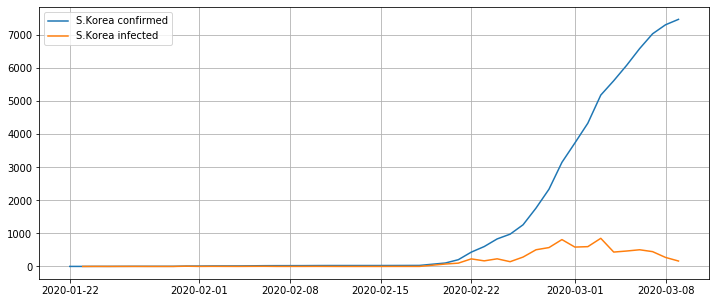

In [34]:
import matplotlib.pyplot as plt 
%matplotlib inline

fig=plt.figure(figsize=(12,5))
plt.plot(korea_df['day'], korea_df['Confirmed'], label="S.Korea confirmed")
plt.plot(korea_df['day'], korea_df['infected'], label='S.Korea infected')
plt.grid(True)
plt.legend()
plt.show()

In [35]:
total_population = 51_470_000
infected_population = korea_df.loc[2:]['infected']
nb_steps = len(infected_population)

In [36]:
def sumsq_error(parameters):
    beta, gamma = parameters
    
    def SIS(t, y):
        S = y[0]
        I = y[1]
        return([-beta*S*I+gamma*I, beta*S*I-gamma*I])

    solution = solve_ivp(SIS, [0, nb_steps-1], [total_population*0.001, 1], t_eval=np.arange(0, nb_steps, 1))
    
    return(sum((solution.y[1]-infected_population)**2))

In [37]:
%%time
from scipy.optimize import minimize

msol = minimize(sumsq_error, [0.001, 0.1], method='Nelder-Mead')
msol.x

Wall time: 4.79 s


array([-0.00038046,  0.20686027])

In [38]:
beta_optimal = -0.00038046
gamma_optimal = 0.20686027

### La valeur optimale pour Beta est irréaliste, alors nous utilisons la valeur 0.01 (c'est à dire qu'un pourcent des contacts entrainent transmission)

In [42]:
beta = 0.01
gamma = gamma_optimal

def SIS(t, y):
        S = y[0]
        I = y[1]
        return([-beta*S*I+gamma*I, beta*S*I-gamma*I])

solution_korea_optimal = solve_ivp(SIS, [0, 40], [51_470_000*0.001, 1], t_eval=np.arange(0, 40, 1))

In [43]:
df_solution_korea = (pd.DataFrame(data=[solution_korea_optimal.t, solution_korea.y[0], solution_korea.y[1] ])
                      .T
                      .rename(columns={0: "Time", 1: "Susceptible", 2 : "Infected"}))
df_solution_korea

,Time,Susceptible,Infected
0,0.0,51470.000000,1.000000
1,1.0,100.082114,51370.917886
2,2.0,99.983087,51371.016913
3,3.0,99.972175,51371.027825
4,4.0,100.028668,51370.971332
5,5.0,99.994626,51371.005374
6,6.0,100.037271,51370.962729
7,7.0,99.929631,51371.070369
8,8.0,100.058304,51370.941696
9,9.0,99.951281,51371.048719


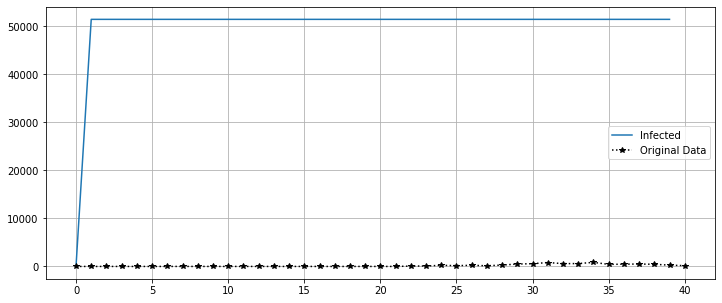

In [44]:
fig = plt.figure(figsize=(12, 5))
plt.plot(solution_korea_optimal.t, solution_korea_optimal.y[1])
plt.plot(korea_df.loc[2:]['infected'].reset_index(drop=True).index, korea_df.loc[2:]['infected'], "k*:")
plt.grid("True")
plt.legend(["Infected", "Original Data"])
plt.show()

Les résultats correspondent aux résultats théoriques du modèle SIS. En effet, avec un taux de guérison définitive nul, la population est rapidement contaminée dans son ensemble. En regardant les chiffres, on peut voir qu'il y a, d'une période à l'autre, une diminution puis une augmentation du nombre d'infectés: les quelques personnes guérissant contact immédiatement le virus de nouveau.
<br>
Enfin, nottons que nos resultats sont mitigés parceque la taille de la population à dû être modifiée par soucis de charge calculatoire.

### Le modèle SIS semble ne pas correspondre empiriquement à l'épidémie du coronavirus.